# Segmentation

In [2]:
# import library

import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
import matplotlib.pyplot as plt

### 이미지 로드

In [3]:
images = ["airplane.png", "diningtable.png", "sparrow.png"]
labels = ["aeroplane", "diningtable", "bird"]

list_image_path = [ os.path.join(os.getcwd(), "images", image) for image in images ]

img_origs = [ cv2.imread(image_path) for image_path in list_image_path ]

for img_orig in img_origs:
    print(img_orig.shape)

(183, 275, 3)
(449, 600, 3)
(183, 275, 3)


### segmentation

In [4]:
# 모델 다운로드

model_path = os.path.join(os.getcwd(), "models")

model_file = os.path.join(model_path, "deeplabv3_xception_tf_dim_ordering_tf_kernels.h5")

model_url = "https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7b1f4052aa60>)

In [5]:
# 모델 생성

model = semantic_segmentation() # semantic segmentation 모델 클래스
model.load_pascalvoc_model(model_file) # pascal voc 데이터세 훈련 모델 로드

In [6]:
# 이미지 분할

def segment(img_path):
    return model.segmentAsPascalvoc(img_path)
    
seg_imgs = [ segment(img_path) for img_path in list_image_path ]

In [7]:
def get_color_bgr(label): # 해당 label 색상을 반환하는 함수
    LABEL_NAMES = np.array([
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ])
    index = np.where(LABEL_NAMES==label)
    
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    
    color = colormap[index][0]
    r, g, b = color[0], color[1], color[2]
    bgr = np.hstack([b, g, r])
    
    return bgr

In [8]:
# 각 색상 확인
seg_colors = [ get_color_bgr(label) for label in labels ]
print(list(zip(labels, seg_colors)))

[('aeroplane', array([  0,   0, 128])), ('diningtable', array([  0, 128, 192])), ('bird', array([  0, 128, 128]))]


In [9]:
# 데이터 합치기 - 원본이미지, 세그먼트, 색상
img_seg_set = list(zip(img_origs, labels, seg_imgs, seg_colors))

(183, 275)
(449, 600)
(183, 275)


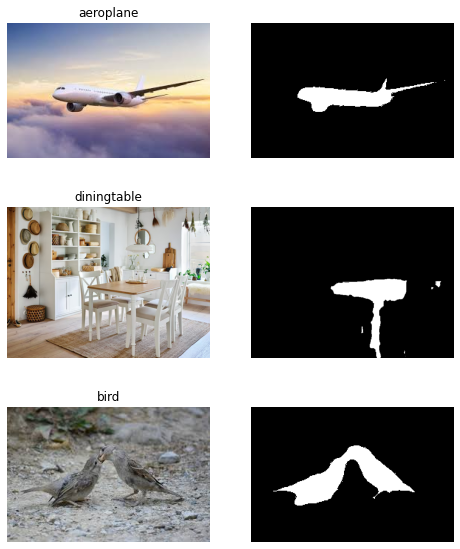

In [10]:
# 필터 시각화

def show_segment(ax, output, color):
    seg_map = np.all(output==color, axis=-1) 
    print(seg_map.shape) 
    ax.axis("off")
    ax.imshow(seg_map, cmap='gray')

fig, axes = plt.subplots(3, 2, figsize=(8, 10))

for idx, (img_orig, label, seg_img, seg_color) in enumerate(img_seg_set):
    axes[idx][0].set_title(label)
    axes[idx][0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    axes[idx][0].axis("off")
    show_segment(axes[idx][1], seg_img[1], seg_color)

plt.show()

In [11]:
# 데이터셋 함수 구현

def make_segment_dataset(model, images, labels, render=True):
    
    # 이미지 로드
    list_image_path = [ os.path.join(os.getcwd(), "images", image) for image in images ]
    img_origs = [ cv2.imread(image_path) for image_path in list_image_path ]
    
    # segmentation
    seg_imgs = [ segment(img_path) for img_path in list_image_path ]
    seg_colors = [ get_color_bgr(label) for label in labels ]
    concat = list(zip(img_origs, labels, seg_imgs, seg_colors))
    
    # 이미지 확인
    img_count = len(images)
    cols = 2
    rows = (img_count*2 // cols) + (img_count*2 % cols)

    fig, axes = plt.subplots(rows, cols, figsize=(8, img_count*5))

    mask_colors = []
    
    if render:
        for idx, (img_orig, label, seg_img, seg_color) in enumerate(concat):
            ax_orig = axes[idx][0]
            ax_seg_map = axes[idx][1]

            ax_orig.set_title(label)
            ax_orig.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
            ax_orig.axis("off")

            seg_map = np.all(seg_img[1]==seg_color, axis=-1) 
            ax_seg_map.axis("off")
            ax_seg_map.imshow(seg_map, cmap='gray')

            mask_color = seg_map.astype(np.uint8) * 255
            mask_color = cv2.cvtColor(mask_color, cv2.COLOR_GRAY2BGR)
            mask_colors.append(mask_color)

        plt.show()
    
    img_seg_set = list(zip(img_origs, labels, mask_colors))
    
    return img_seg_set

### 크로마키 배경

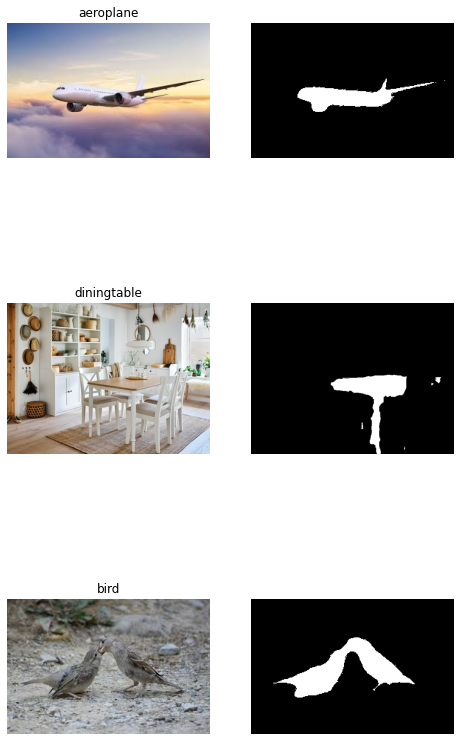

In [12]:
seg_dataset = make_segment_dataset(model, images, labels)

In [13]:
# 원본 이미지와 겹쳐서 확인
def render_overlay(dataset):

    fig, axes = plt.subplots(len(dataset), 1, figsize=(8, len(dataset)*3))
    
    idx = 0
    
    for img_orig, label, mask_color in dataset:
        
        img_show = img_orig.copy()
        mask_color = cv2.cvtColor(mask_color, cv2.COLOR_BGR2GRAY)
        color_mask = cv2.applyColorMap(mask_color, cv2.COLORMAP_JET)
        img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
        axes[idx].set_title(label)
        axes[idx].axis("off")
        axes[idx].imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
        idx += 1
    plt.show()

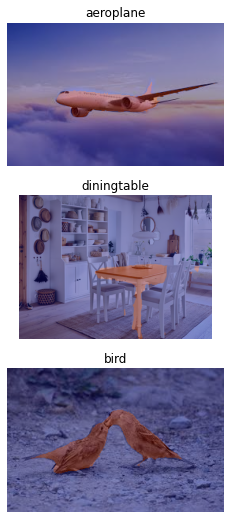

In [14]:
render_overlay(seg_dataset)

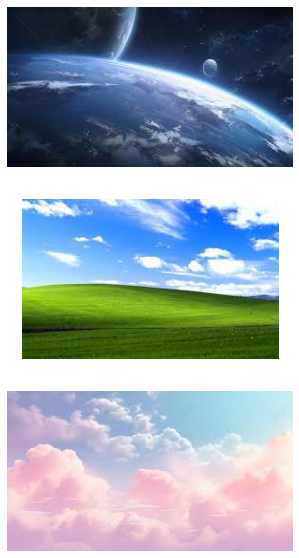

In [15]:
# 배경 교체

background_images = ["bg_earth.png", "bg_window.png", "bg_cloud.png"]
list_image_bg_path = [ os.path.join(os.getcwd(), "images", image) for image in background_images ]
img_bg_origs = [ cv2.imread(image_path) for image_path in list_image_bg_path ]

# 배경 사진 확인
fig, axes = plt.subplots(3, 1, figsize=(8,10))
for idx, img_bg in enumerate(img_bg_origs):
    axes[idx].imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
    axes[idx].axis("off")
plt.show()

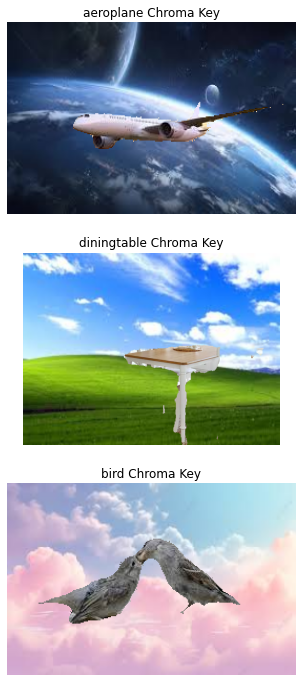

In [16]:
# 크로마키

fig, axes = plt.subplots(len(seg_dataset), 1, figsize=(8, 12))

idx = 0
for (img_orig, label, mask_color), img_bg in zip(seg_dataset, img_bg_origs):
    # 이미지 사이즈 맞추기
    img_bg = cv2.resize(img_bg, (img_orig.shape[1], img_orig.shape[0]))
    
    # 픽셀 필터링
    img_concat = np.where(mask_color==255, img_orig, img_bg)

    # 이미지 확인
    axes[idx].set_title(f"{label} Chroma Key")
    axes[idx].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    axes[idx].axis("off")
    idx += 1
plt.show()


### 아웃포커싱

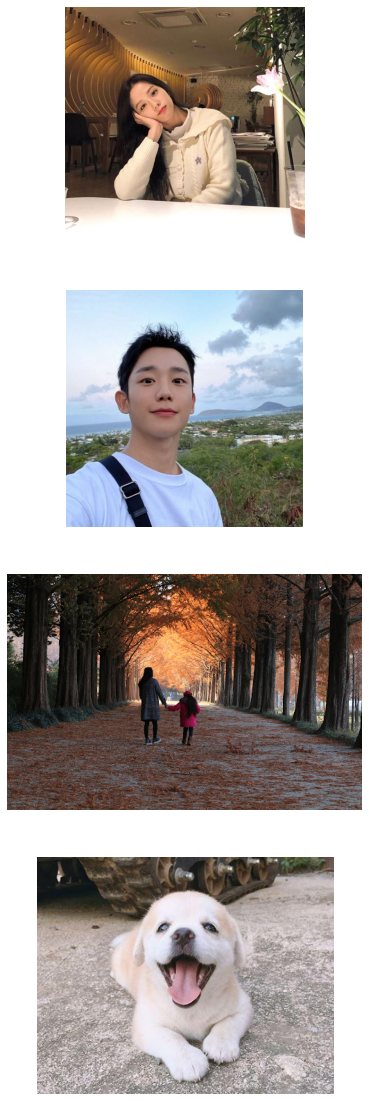

In [17]:
# 이미지 로드
outfc_images = ["jisoo.png", "jhi.png", "twoperson.png", "puppy.png"]
outfc_labels = ["person"] * 3 + ["dog"]
list_image_outfc_path = [ os.path.join(os.getcwd(), "images", image) for image in outfc_images ]
img_outfc_origs = [ cv2.imread(image_path) for image_path in list_image_outfc_path ]
outfc_size = len(outfc_images)

# 인물 이미지 확인
fig, axes = plt.subplots(outfc_size, 1, figsize=(8, outfc_size*5))
for idx, img_ps in enumerate(img_outfc_origs):
    axes[idx].imshow(cv2.cvtColor(img_ps, cv2.COLOR_BGR2RGB))
    axes[idx].axis("off")
plt.show()

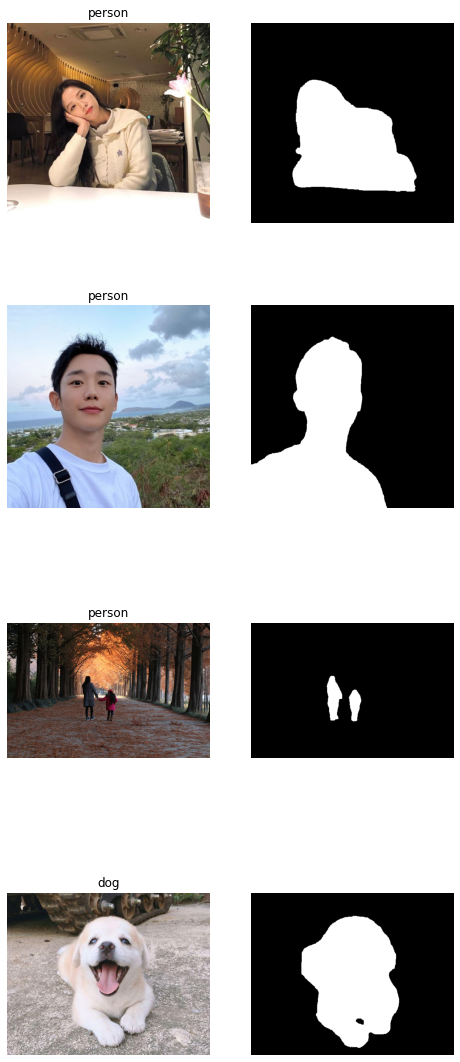

In [19]:
# segmentation
outfc_dataset = make_segment_dataset(model, outfc_images, outfc_labels)

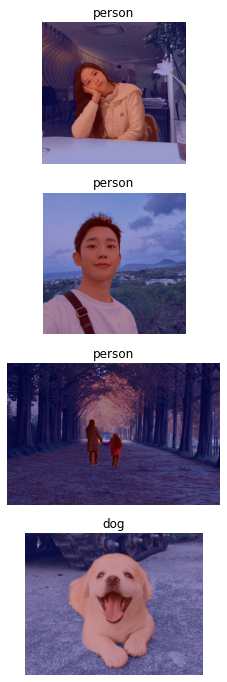

In [20]:
# segmentation 영역 씌운 이미지 확인
render_overlay(outfc_dataset)

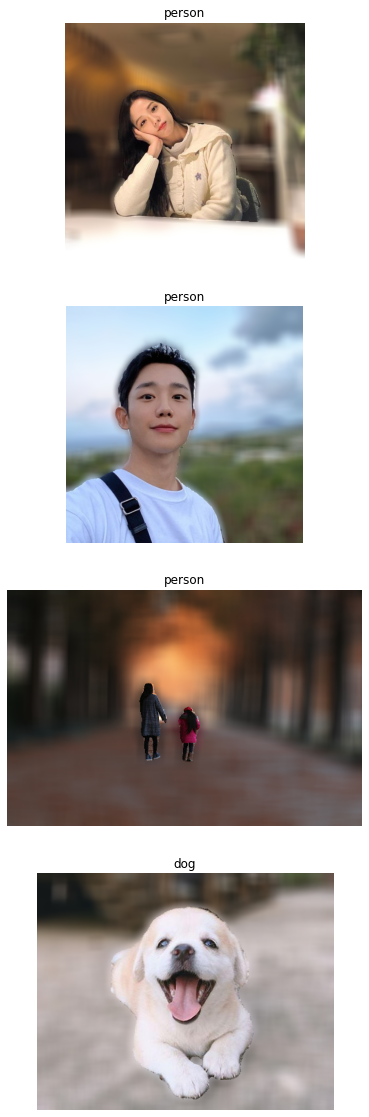

In [21]:
# 아웃포커스 사진 구현

fig, axes = plt.subplots(outfc_size, 1, figsize=(10, outfc_size*5))

idx = 0
for img_orig, label, mask_color in outfc_dataset:
    # 기존 사진 블러처리
    img_blur = cv2.blur(img_orig, ksize=(27, 27))
    # 픽셀 필터링
    img_concat = np.where(mask_color==255, img_orig, img_blur)
    # 이미지 확인
    axes[idx].set_title(label)
    axes[idx].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    axes[idx].axis("off")
    idx += 1
plt.show()

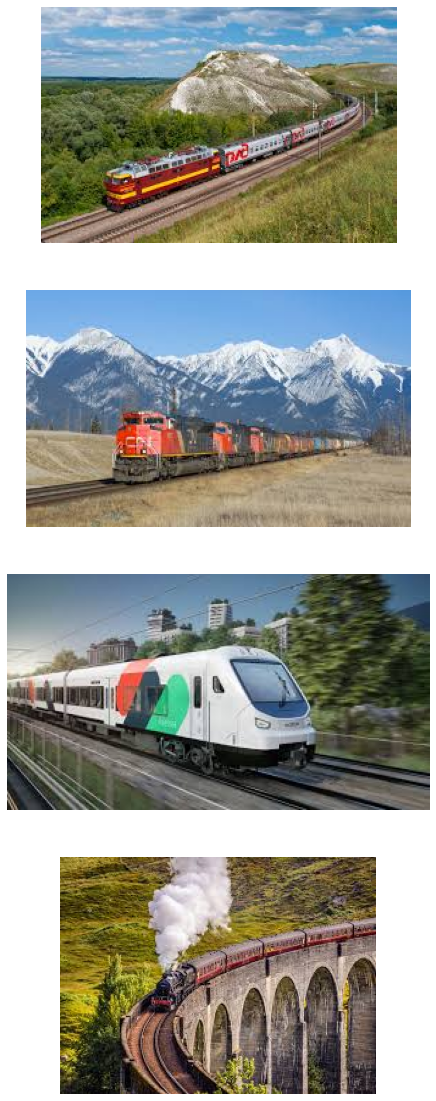

In [22]:
# 기차 segmentation

# 이미지 로드
train_images = ["train_1.png", "train_2.png", "train_3.png", "train_4.png"]
train_labels = ["train"] * 4
list_image_train_path = [ os.path.join(os.getcwd(), "images", image) for image in train_images ]
img_train_origs = [ cv2.imread(image_path) for image_path in list_image_train_path ]
train_size = len(train_images)

# 인물 이미지 확인
fig, axes = plt.subplots(outfc_size, 1, figsize=(8, train_size*5))

for idx, img_ps in enumerate(img_train_origs):
    axes[idx].imshow(cv2.cvtColor(img_ps, cv2.COLOR_BGR2RGB))
    axes[idx].axis("off")
plt.show()

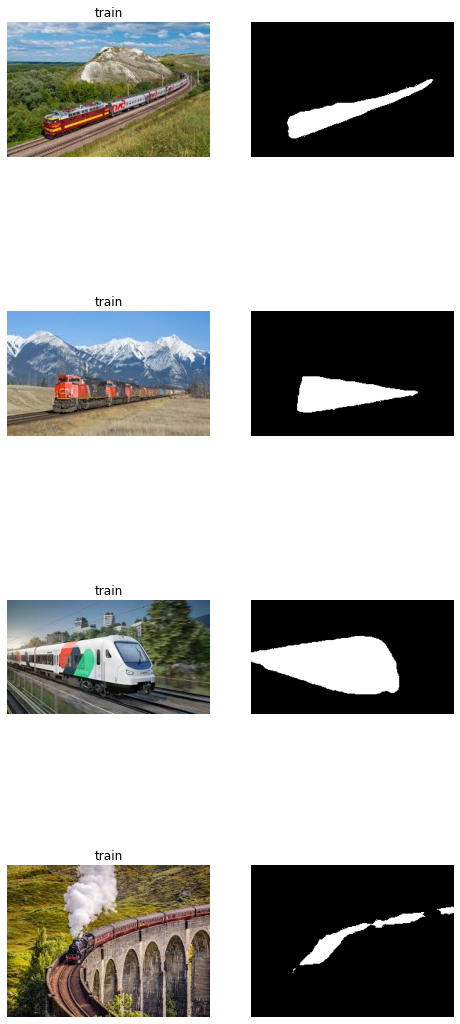

In [25]:
# 기차 semantic 데이터셋
train_dataset = make_segment_dataset(model, train_images, train_labels)

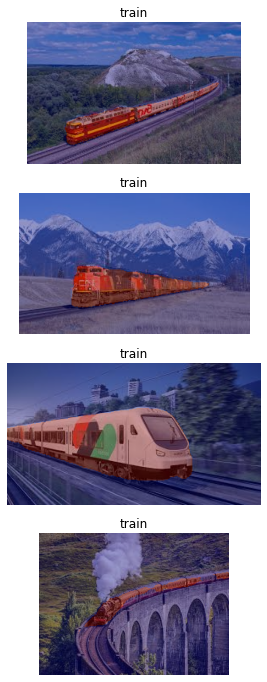

In [26]:
render_overlay(train_dataset)

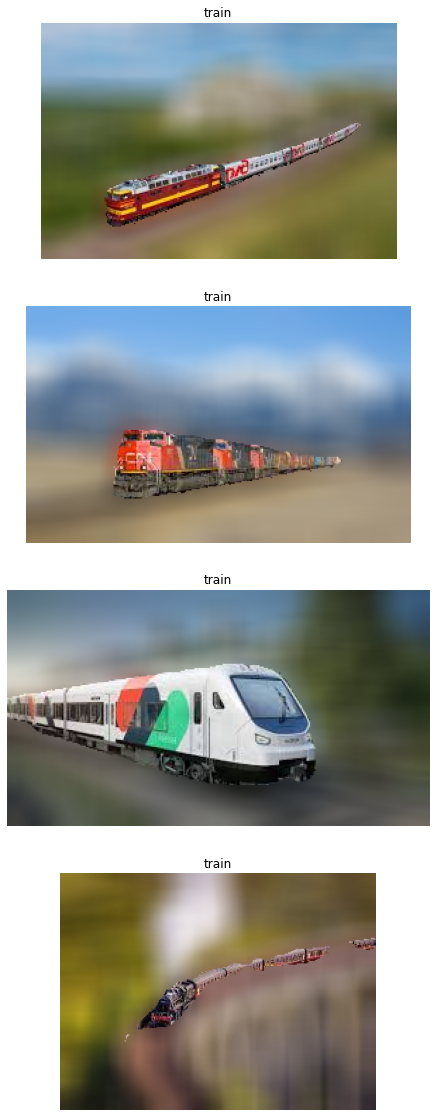

In [27]:
# 기차

fig, axes = plt.subplots(outfc_size, 1, figsize=(10, train_size*5))

idx = 0
for img_orig, label, mask_color in train_dataset:
    # 기존 사진 블러처리
    img_blur = cv2.blur(img_orig, ksize=(27, 27))
    # 픽셀 필터링
    img_concat = np.where(mask_color==255, img_orig, img_blur)
    # 이미지 확인
    axes[idx].set_title(label)
    axes[idx].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    axes[idx].axis("off")
    idx += 1
plt.show()

### 발견한 문제점과 개선을 위한 솔루션
* 작은 영역에 대해서는 잘 분할하지 못한다.
  - 이미지를 다양한 해상도로 변환하여 각각의 해상도에서 분할을 수행하는 방법이 있다.
  - 스케일 변환 데이터 증강으로 조금 더 다양한 크기의 객체를 인식할 수 있도록 훈련하는 방법이 있다.
  - 세그멘테이션 결과를 개선하기 여러가지 후처리 기술을 적용할 수 있다고한다.
* 인물 사진의 경우 인접한 사물에 대해 구분하지 못하는 경우가 있다.
  - 보다 정교한 아키텍쳐를 가진 네트워크로 학습시킨다.
  - 고품질의 어노테이션 데이터를 활용하여 사물과의 경계를 명확히 구분할 수 있도록 학습시킨다.
  - 인물과 배경의 컨텍스트 정보를 활용하여 분할 성능을 향상시킬 수 있다.
* 복잡하고 촘촘한 사진일 수록 제대로 분할하지 못한다.
  - 강화학습을 통해 복잡한 장면에서의 분할 성능을 높일 수 있다고 한다.
  - [blog](https://velog.io/@everyman123/Actor-Critic-Instance-Segmentation-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0), [Paper](https://ieeexplore.ieee.org/document/8954189)
* 미세한 경계는 잘 구별하지 못하는 경우가 있다.
  - 높은 해상도의 이미지 데이터로 학습시켜 더 많은 디테일을 반영할 수 있도록 한다.
* 3D데이터, Point Cloud 데이터 등을 활용해 Segmentation 하는 방법들이 있다.

# 회고
* 배운 점: Instance segmentation을 활용해 이미지 데이터를 처리하는 방법을 학습할 수 있었다.
* 아쉬운 점: 더 다양한 태스크를 고민하고 구현해보지 못해서 아쉬웠다.
* 느낀 점: segmentatoin의 발전과정과 핵심원리, 아이디이어에 대해 더 깊게 공부해봐야겠다고 느꼈다.
* 어려웠던 점: 많은 이미지 처리 방식에 대해 아직 익숙하지 않아서 어려웠다.